In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [ ]:
import os
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.model_selection import train_test_split, StratifiedKFold
from evaluate import calculate_metrics
from rasterio.errors import NotGeoreferencedWarning
from visualization import plot_image_and_mask_and_prediction
from utils import load_and_normalize_tiff,load_mask,generate_tiles
from data_loader import ClassicalCloudDataset
from preprocessing import calculate_spectral_indices,extract_features
from config import config
from models.ensemble import EnsembleModel

warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

In [ ]:
# ============================================================================
# Evaluation and Metrics
# ============================================================================
def save_metrics(metrics, name, output_dir):
    """Save metrics to JSON file"""
    log_dir = output_dir / "logs"
    os.makedirs(log_dir, exist_ok=True)
    
    metrics_path = log_dir / f"{name}_metrics.json"
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    print(f"Saved {name} metrics to {metrics_path}")

def plot_feature_importance(model, output_path=None):
    """Plot feature importance if available"""
    if model.feature_importances is not None and model.selected_features is not None:
        plt.figure(figsize=(12, 8))
        
        # Only plot for selected features
        indices = np.argsort(model.feature_importances)[-20:]  # Top 20 features
        plt.barh(range(len(indices)), model.feature_importances[indices])
        plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Important Features')
        
        if output_path:
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"Feature importance plot saved to {output_path}")
        else:
            plt.show()
        
        plt.close()

In [ ]:
# ============================================================================
# Cross-Validation
# ============================================================================
def cross_validate(image_pairs, n_folds=5, random_state=42):
    """Perform cross-validation"""
    print(f"Starting {n_folds}-fold cross-validation...")
    
    # Prepare folds
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Extract categories for stratification
    categories = [category for _, _, category in image_pairs]
    category_ids = {cat: i for i, cat in enumerate(set(categories))}
    stratify_values = [category_ids[cat] for cat in categories]
    
    cv_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(image_pairs, stratify_values)):
        print(f"\nFold {fold+1}/{n_folds}")
        
        # Split data
        train_pairs = [image_pairs[i] for i in train_idx]
        val_pairs = [image_pairs[i] for i in val_idx]
        
        # Create datasets
        train_ds = ClassicalCloudDataset(
            train_pairs, 
            mode='train',
            feature_cache_dir=config.FEATURES_PATH / f"fold_{fold+1}_train"
        )
        val_ds = ClassicalCloudDataset(
            val_pairs, 
            mode='val',
            feature_cache_dir=config.FEATURES_PATH / f"fold_{fold+1}_val"
        )
        
        # Calculate class weights
        class_weights = train_ds.calculate_class_weights()
        
        # Initialize and train model
        model = EnsembleModel()
        val_history = model.fit(
            train_ds.batch_generator,
            val_ds.batch_generator,
            class_weights
        )
        
        # Get best validation metrics
        best_metrics = max(val_history, key=lambda x: x['f1']) if val_history else None
        if best_metrics:
            print(f"Fold {fold+1} best F1: {best_metrics['f1']:.4f}")
            cv_metrics.append(best_metrics)
            
            # Save fold-specific model
            model.save(config.MODEL_PATH / f"model_fold_{fold+1}.joblib")
    
    # Calculate average metrics
    if cv_metrics:
        avg_metrics = {
            'accuracy': np.mean([m['accuracy'] for m in cv_metrics]),
            'precision': np.mean([m['precision'] for m in cv_metrics]),
            'recall': np.mean([m['recall'] for m in cv_metrics]),
            'f1': np.mean([m['f1'] for m in cv_metrics])
        }
        
        if 'roc_auc' in cv_metrics[0]:
            avg_metrics['roc_auc'] = np.mean([m['roc_auc'] for m in cv_metrics])
        
        print("\nCross-Validation Results:")
        print(f"Avg Accuracy: {avg_metrics['accuracy']:.4f}")
        print(f"Avg Precision: {avg_metrics['precision']:.4f}")
        print(f"Avg Recall: {avg_metrics['recall']:.4f}")
        print(f"Avg F1 Score: {avg_metrics['f1']:.4f}")
        if 'roc_auc' in avg_metrics:
            print(f"Avg ROC AUC: {avg_metrics['roc_auc']:.4f}")
        
        # Save CV metrics
        all_cv_data = {
            'folds': cv_metrics,
            'average': avg_metrics
        }
        save_metrics(all_cv_data, 'cross_validation', config.OUTPUT_PATH)
    
    return cv_metrics

In [ ]:
# ============================================================================
# Prediction and Visualization
# ============================================================================
def predict_full_image(model, image_path):
    """Predict cloud mask for a full image with tiling"""
    # Load image
    image = load_and_normalize_tiff(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    
    # Process image in tiles to save memory
    img_tiles, coords = generate_tiles(image, config.TILE_SIZE)
    h, w = image.shape[1], image.shape[2]
    
    # Initialize full mask
    full_mask = np.zeros((h, w), dtype=np.float32)
    
    # Process each tile
    for tile, (y, x) in zip(img_tiles, coords):
        # Extract features
        indices = calculate_spectral_indices(tile)
        features = extract_features(tile, indices)
        
        # Get probabilities
        proba = model.predict_proba(features)
        
        # Reshape to tile shape
        tile_mask = proba.reshape(config.TILE_SIZE, config.TILE_SIZE)
        
        # Place in full mask
        full_mask[y:y+config.TILE_SIZE, x:x+config.TILE_SIZE] = tile_mask
    
    if config.POST_PROCESS:
        high_threshold = 0.75
        low_threshold = 1.0  # Adjust based on your proba_map scale
        cloud_free_threshold = 0.05

        strong_clouds = full_mask > high_threshold
        weak_clouds = (full_mask > low_threshold) & (full_mask <= high_threshold)
        cloud_free = full_mask < cloud_free_threshold

        # Small dilation on strong clouds
        struct = ndimage.generate_binary_structure(2, 2)
        dilated_strong = ndimage.binary_dilation(strong_clouds, structure=struct, iterations=1)

        # Connect weak clouds near strong clouds
        final_mask = dilated_strong.copy()
        labeled_weak, num_labels = ndimage.label(weak_clouds)

        for label in range(1, num_labels + 1):
            weak_region = (labeled_weak == label)
            if np.any(dilated_strong & weak_region):
                final_mask |= weak_region

        # Fill small holes in detected cloud regions
        final_mask = ndimage.binary_fill_holes(final_mask)

        # Remove small isolated patches (e.g., < 20 pixels)
        labeled_final, num_labels = ndimage.label(final_mask)
        component_sizes = np.bincount(labeled_final.ravel())
        small_components = component_sizes < 20
        small_components[0] = False  # background stays
        final_mask[small_components[labeled_final]] = False
        
        final_mask[cloud_free] = False
        
        # Optional smoothing
        final_mask = ndimage.binary_closing(
            final_mask, structure=np.ones((config.MORPHOLOGY_SIZE, config.MORPHOLOGY_SIZE))
        )

        binary_mask = final_mask.astype(np.uint8)
        
    else:
        binary_mask = (full_mask > config.PROBABILITY_THRESHOLD).astype(np.uint8)

    
    return image,binary_mask

# ============================================================================
# Main Pipeline
# ============================================================================

In [12]:
print("Cloud Detection Pipeline")
print("=======================")

# 1. Find and list image pairs
print("Finding image pairs...")
image_pairs = []
for category in ['cloud_free', 'partially_clouded', 'fully_clouded']:
    img_dir = config.PROCESSED_DATA / "data" / category
    mask_dir = config.PROCESSED_DATA / "masks" / category
    
    if not img_dir.exists() or not mask_dir.exists():
        print(f"Warning: Directory not found: {img_dir} or {mask_dir}")
        continue
    
    matched = [
        (img_file, mask_dir / img_file.name, category)
        for img_file in img_dir.glob('*.tif')
        if (mask_dir / img_file.name).exists()
    ]
    
    # Limit samples per category if needed
    if config.SAMPLES_PER_CATEGORY > 0:
        np.random.shuffle(matched)
        matched = matched[:config.SAMPLES_PER_CATEGORY]
    
    image_pairs.extend(matched)

print(f"Found {len(image_pairs)} image pairs")
if not image_pairs:
    print("No image pairs found. Check your data paths.")
    exit(1)

Cloud Detection Pipeline
Finding image pairs...
Found 900 image pairs


In [14]:
# 2. Split data
print("\nSplitting datasets...")
train_pairs, val_test_pairs = train_test_split(
    image_pairs,
    test_size=config.VAL_SPLIT + config.TEST_SPLIT,
    random_state=42
)

val_pairs, test_pairs = train_test_split(
    val_test_pairs,
    test_size=config.TEST_SPLIT / (config.VAL_SPLIT + config.TEST_SPLIT),
    random_state=42
)

print(f"Train: {len(train_pairs)}, Validation: {len(val_pairs)}, Test: {len(test_pairs)}")


Splitting datasets...
Train: 629, Validation: 180, Test: 91


In [ ]:
# 3. Create datasets with caching
train_ds = ClassicalCloudDataset(
    train_pairs,
    mode='train',
    feature_cache_dir=config.FEATURES_PATH / "train"
)

val_ds = ClassicalCloudDataset(
    val_pairs,
    mode='val',
    feature_cache_dir=config.FEATURES_PATH / "val"
)

test_ds = ClassicalCloudDataset(
    test_pairs,
    mode='test',
    feature_cache_dir=config.FEATURES_PATH / "test"
)

In [16]:
# 4. Calculate class weights
print("\nCalculating class weights...")
class_weights = train_ds.calculate_class_weights()
print(f"Class weights: {class_weights}")


Calculating class weights...
Class weights: {0: 0.9374655127798706, 1: 1.0714736195120327}


In [ ]:
# 5. Run cross-validation or train single model
if config.CROSS_VAL_FOLDS > 1:
    print("\nRunning cross-validation...")
    cv_metrics = cross_validate(train_pairs, config.CROSS_VAL_FOLDS)
    
    # Load best model from cross-validation
    best_model_path = config.MODEL_PATH / "model_fold_1.joblib"  # Default to first fold
    if cv_metrics:
        # Find best fold
        best_f1 = 0
        best_fold = 1
        for fold, metrics in enumerate(cv_metrics, 1):
            if metrics['f1'] > best_f1:
                best_f1 = metrics['f1']
                best_fold = fold
        best_model_path = config.MODEL_PATH / f"model_fold_{best_fold}.joblib"
    
    print(f"Loading best model from {best_model_path}")
    model = EnsembleModel.load(best_model_path)
else:
    # Train a single model
    print("\nTraining model...")
    model = EnsembleModel()
    model.fit(
        train_ds.batch_generator,
        val_ds.batch_generator,
        class_weights
    )


Running cross-validation...
Starting 3-fold cross-validation...

Fold 1/3
Starting model training...


Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Initial data shape: (512, 71)
Performing feature selection...
Selected 30 features out of 71
Creating model...

Epoch 1/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8569 | Best: 0.0000
Model saved to ..\outputs\models\best_model.joblib
↑ New best model saved ↑

Epoch 2/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8401 | Best: 0.8569
No improvement (1/4)

Epoch 3/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8753 | Best: 0.8569
Model saved to ..\outputs\models\best_model.joblib
↑ New best model saved ↑

Epoch 4/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8267 | Best: 0.8753
No improvement (1/4)

Epoch 5/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8429 | Best: 0.8753
No improvement (2/4)

Epoch 6/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8727 | Best: 0.8753
No improvement (3/4)

Epoch 7/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8538 | Best: 0.8753
No improvement (4/4)
Early stopping triggered at epoch 7!
Model saved to ..\outputs\models\final_model.joblib
Fold 1 best F1: 0.8753
Model saved to ..\outputs\models\model_fold_1.joblib

Fold 2/3
Starting model training...


Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Initial data shape: (512, 71)
Performing feature selection...
Selected 30 features out of 71
Creating model...

Epoch 1/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8273 | Best: 0.0000
Model saved to ..\outputs\models\best_model.joblib
↑ New best model saved ↑

Epoch 2/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8209 | Best: 0.8273
No improvement (1/4)

Epoch 3/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.7928 | Best: 0.8273
No improvement (2/4)

Epoch 4/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8047 | Best: 0.8273
No improvement (3/4)

Epoch 5/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/419 [00:00<?, ?it/s]

Fitting model on 3432448 samples...
Trained on 6704 batches


Processing val data:   0%|          | 0/210 [00:00<?, ?it/s]

Val F1: 0.8085 | Best: 0.8273
No improvement (4/4)
Early stopping triggered at epoch 5!
Model saved to ..\outputs\models\final_model.joblib
Fold 2 best F1: 0.8273
Model saved to ..\outputs\models\model_fold_2.joblib

Fold 3/3
Starting model training...


Processing train data:   0%|          | 0/420 [00:00<?, ?it/s]

Initial data shape: (512, 71)
Performing feature selection...
Selected 30 features out of 71
Creating model...

Epoch 1/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/420 [00:00<?, ?it/s]

Fitting model on 3440640 samples...
Trained on 6720 batches


Processing val data:   0%|          | 0/209 [00:00<?, ?it/s]

Val F1: 0.8510 | Best: 0.0000
Model saved to ..\outputs\models\best_model.joblib
↑ New best model saved ↑

Epoch 2/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/420 [00:00<?, ?it/s]

Fitting model on 3440640 samples...
Trained on 6720 batches


Processing val data:   0%|          | 0/209 [00:00<?, ?it/s]

Val F1: 0.8555 | Best: 0.8510
Model saved to ..\outputs\models\best_model.joblib
↑ New best model saved ↑

Epoch 3/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/420 [00:00<?, ?it/s]

Fitting model on 3440640 samples...
Trained on 6720 batches


Processing val data:   0%|          | 0/209 [00:00<?, ?it/s]

Val F1: 0.8544 | Best: 0.8555
No improvement (1/4)

Epoch 4/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/420 [00:00<?, ?it/s]

Fitting model on 3440640 samples...
Trained on 6720 batches


Processing val data:   0%|          | 0/209 [00:00<?, ?it/s]

Val F1: 0.8402 | Best: 0.8555
No improvement (2/4)

Epoch 5/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/420 [00:00<?, ?it/s]

Fitting model on 3440640 samples...
Trained on 6720 batches


Processing val data:   0%|          | 0/209 [00:00<?, ?it/s]

Val F1: 0.8023 | Best: 0.8555
No improvement (3/4)

Epoch 6/20


Training: 0it [00:00, ?it/s]

Processing train data:   0%|          | 0/420 [00:00<?, ?it/s]

Fitting model on 3440640 samples...
Trained on 6720 batches


Processing val data:   0%|          | 0/209 [00:00<?, ?it/s]

Val F1: 0.8338 | Best: 0.8555
No improvement (4/4)
Early stopping triggered at epoch 6!
Model saved to ..\outputs\models\final_model.joblib
Fold 3 best F1: 0.8555
Model saved to ..\outputs\models\model_fold_3.joblib

Cross-Validation Results:
Avg Accuracy: 0.8642
Avg Precision: 0.8569
Avg Recall: 0.8489
Avg F1 Score: 0.8527
Avg ROC AUC: 0.9399
Saved cross_validation metrics to ..\outputs\logs\cross_validation_metrics.json
Loading best model from ..\outputs\models\model_fold_1.joblib


In [ ]:
best_model_path = config.MODEL_PATH / "Classical_model.joblib"
print(f"Loading best model from {best_model_path}")
model = EnsembleModel.load(best_model_path)

Loading best model from ..\outputs\models\model_fold_1.joblib


In [20]:
# 6. Final evaluation on test set
print("\nEvaluating on test set...")
test_preds, test_true, test_proba = [], [], []

for X_test, y_test in test_ds.batch_generator():
    test_preds.extend(model.predict(X_test))
    test_true.extend(y_test)
    test_proba.extend(model.predict_proba(X_test))

if test_true:
    test_metrics = calculate_metrics(test_true, test_preds, test_proba)
    print("\nTest Set Results:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    if 'roc_auc' in test_metrics:
        print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
    
    # Save test metrics
    save_metrics(test_metrics, 'test', config.OUTPUT_PATH)


Evaluating on test set...


Processing test data:   0%|          | 0/91 [00:00<?, ?it/s]

Cache write error for 876909.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\876909_features.npz'
Cache write error for 511484.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\511484_features.npz'
Cache write error for 507135.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\507135_features.npz'
Cache write error for 165417.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\165417_features.npz'
Cache write error for 880550.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\880550_features.npz'
Cache write error for 201987.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\201987_features.npz'
Cache write error for 506945.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\506945_features.npz'
Cache write error for 725113.tif: [Errno 2] No such file or directory: '..\\outputs\\features\\test\\725113_features.npz'
Cache write error for 58

Feature importance plot saved to ..\outputs\logs\feature_importance.png

Generating example predictions...
Predicting for 165417.tif (fully_clouded)...


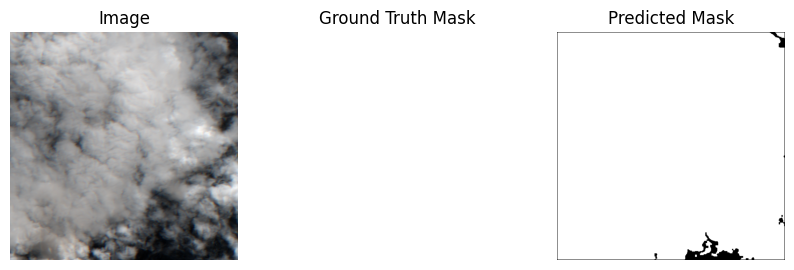

Predicting for 507135.tif (fully_clouded)...


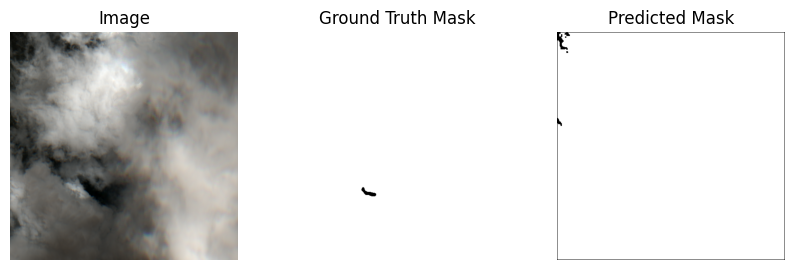

Predicting for 511484.tif (fully_clouded)...


Predicting for 880550.tif (fully_clouded)...


Predicting for 201987.tif (fully_clouded)...


Predicting for 506945.tif (fully_clouded)...


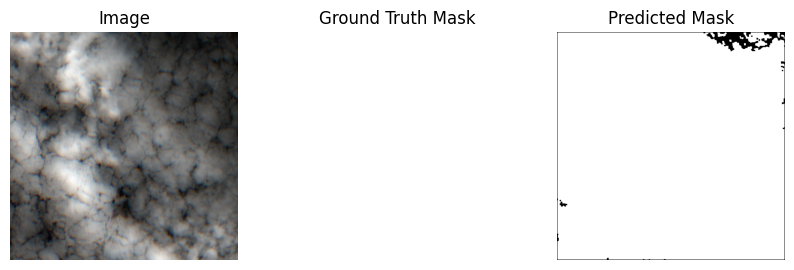

Predicting for 876909.tif (fully_clouded)...


Predicting for 795847.tif (fully_clouded)...


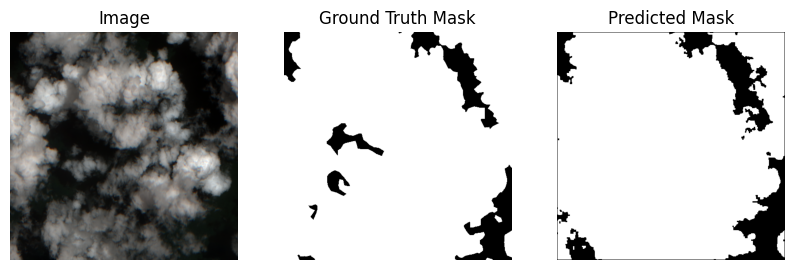

Predicting for 202444.tif (fully_clouded)...


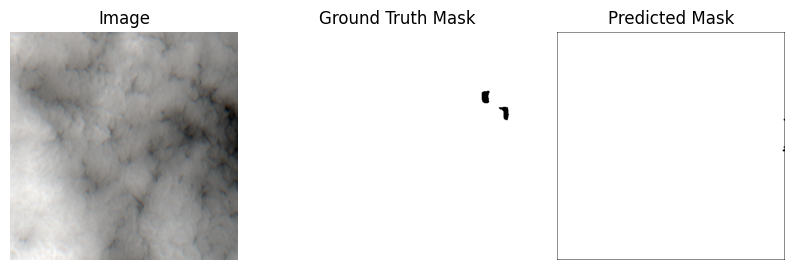

Predicting for 718836.tif (fully_clouded)...


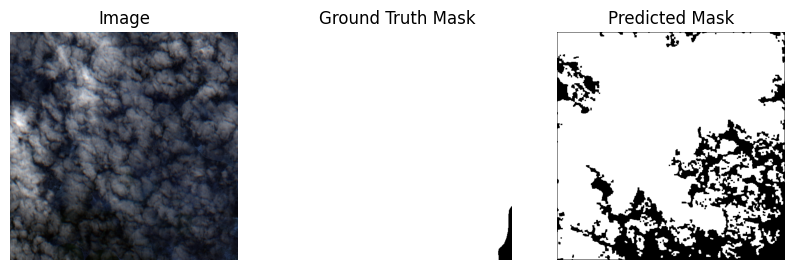

Predicting for 436526.tif (fully_clouded)...


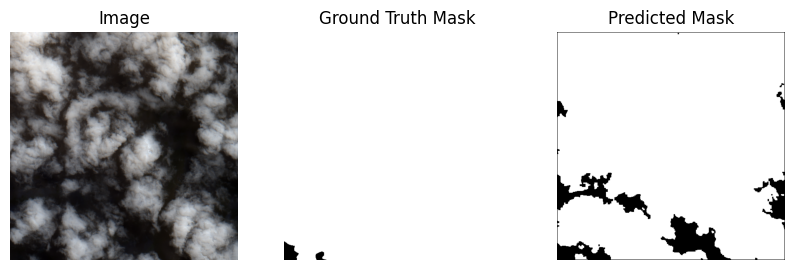

Predicting for 886609.tif (fully_clouded)...


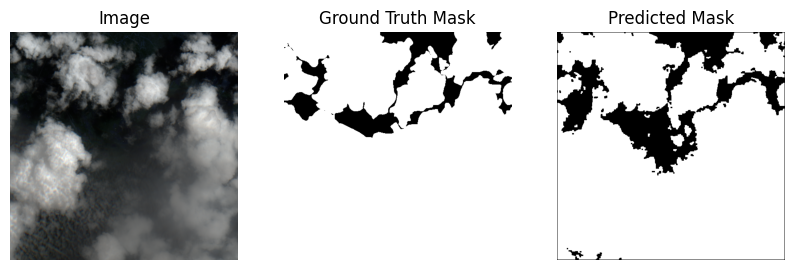

Predicting for 715332.tif (fully_clouded)...


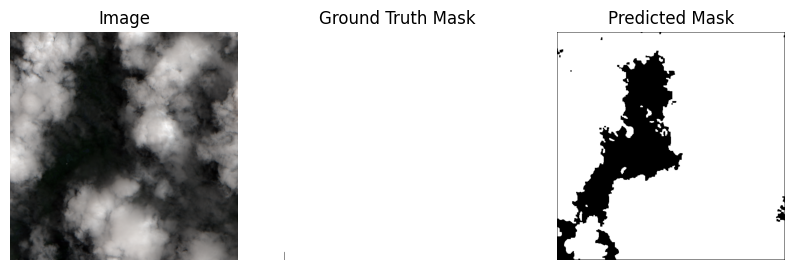

Predicting for 684632.tif (fully_clouded)...


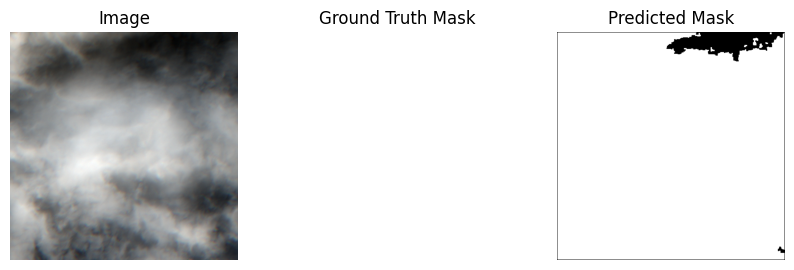

Predicting for 673149.tif (fully_clouded)...


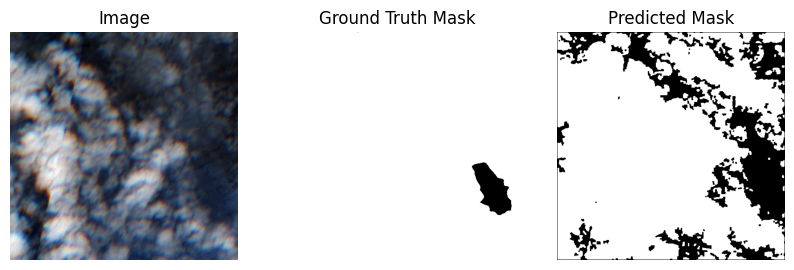

Predicting for 509018.tif (fully_clouded)...


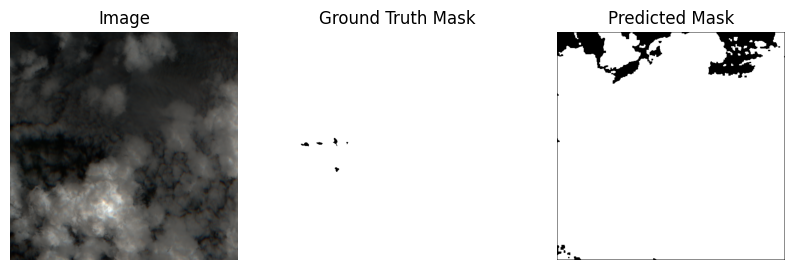

Predicting for 536196.tif (fully_clouded)...


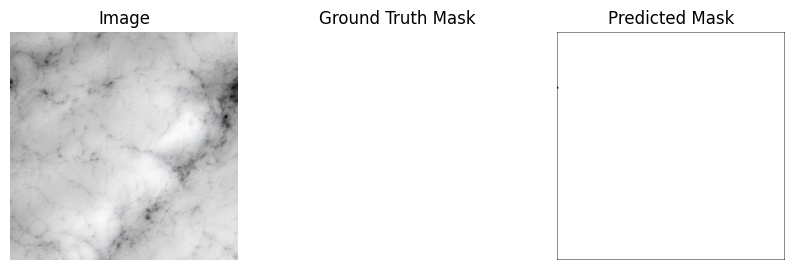

Predicting for 327999.tif (fully_clouded)...


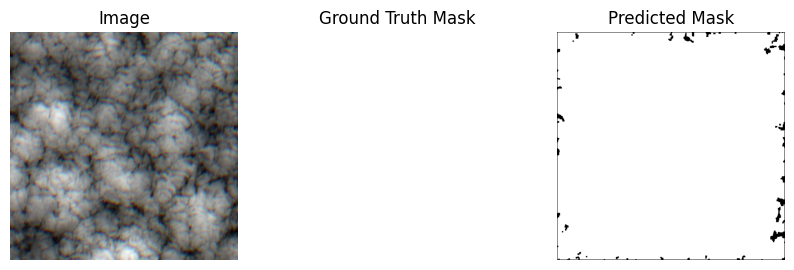

Predicting for 620465.tif (fully_clouded)...


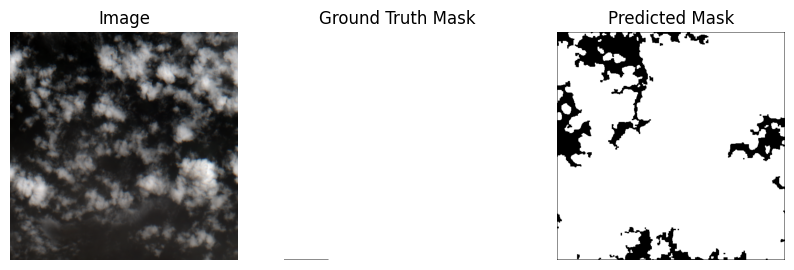

Predicting for 349641.tif (fully_clouded)...


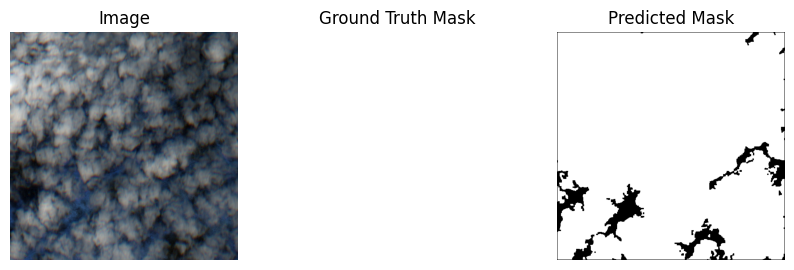

Predicting for 933456.tif (fully_clouded)...


Predicting for 567432.tif (fully_clouded)...


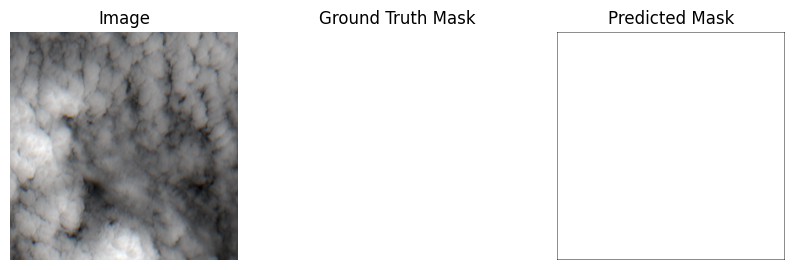

Predicting for 479167.tif (fully_clouded)...


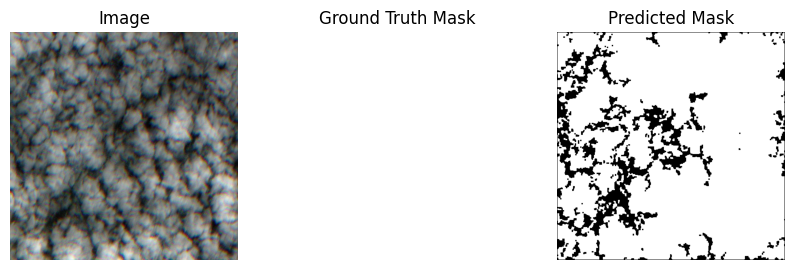

Predicting for 531589.tif (fully_clouded)...


Predicting for 501312.tif (fully_clouded)...


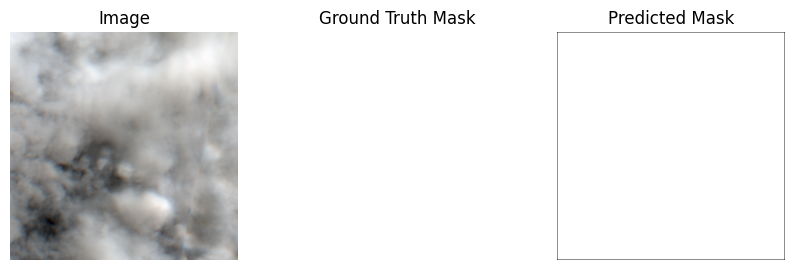

Predicting for 351083.tif (fully_clouded)...


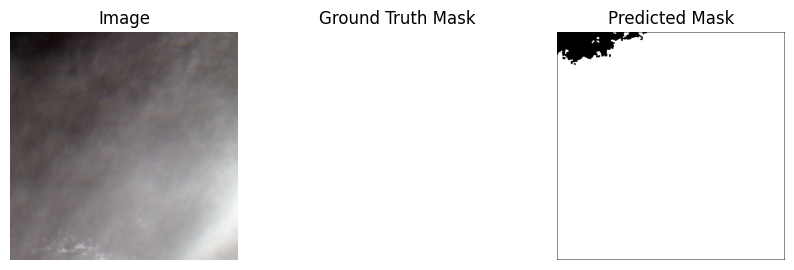

Predicting for 983532.tif (fully_clouded)...


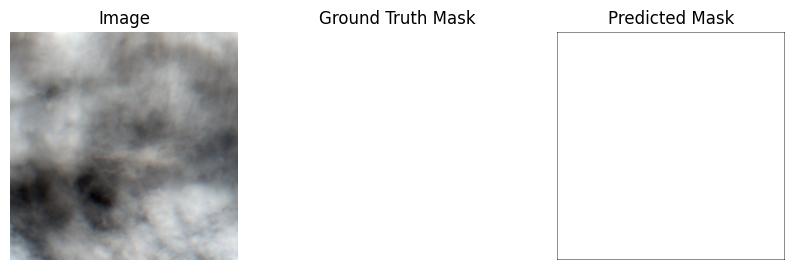

Predicting for 379901.tif (fully_clouded)...


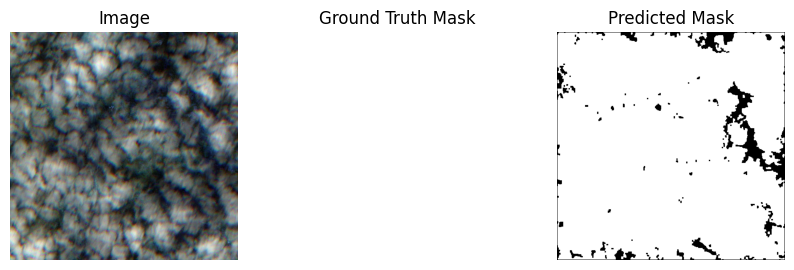

Predicting for 985893.tif (fully_clouded)...


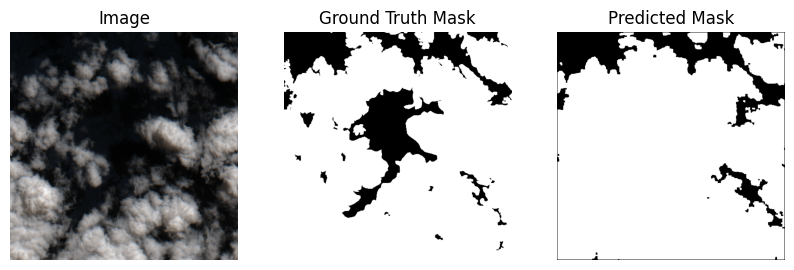

In [ ]:
# 7. Plot feature importance
plot_feature_importance(model, config.OUTPUT_PATH / "logs" / "feature_importance.png")

# 8. Example predictions
print("\nGenerating example predictions...")

for img_path,mask_path, category in test_pairs[:]:
    # if(category != "fully_clouded"):
    #     continue
    print(f"Predicting for {img_path.name} ({category})...")
    output_path = config.OUTPUT_PATH / "predictions" / f"pred_{img_path.stem}.png"
    image,predicted_mask = predict_full_image(model, img_path)
    mask = load_mask(mask_path)
    plot_image_and_mask_and_prediction(image,mask, predicted_mask,title=img_path.stem)
    # Visualize and save if needed
    # plot_image_and_mask(image,predicted_mask,title=img_path.stem,save_path=output_path)